In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24"

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scanpy as sc

from perturbseq import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load mean population and annotate masked_active and expanded_masked_active guides

In [9]:
pops = dict()

pops['fibro'] = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])

Loading matrix...
Loading metadata...
Done in 5.038134813308716s.
Done.
Loading matrix...
Loading metadata...
Done in 5.420777797698975s.
Done.


In [10]:
pops['fibro'].genes.index.name = 'gene_id'

In [11]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
pops['fibro'].cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

del expanded_guides

In [7]:
mean_pop.cells['masked_active'] = pops['fibro'].cells['masked_active']
mean_pop.cells['masked_active'].fillna(False, inplace=True)

# Load atoms extracted from bootstrap resamples

In [8]:
atoms = dict()

In [9]:
file = '20240314_fibroblast_atoms_1_100.hdf'
n_samples = 100
alpha = float(file.split('_')[-2])
n_components = int(file.split('_')[-1].split('.')[0])

atoms['fibro'] = pd.read_hdf(file)

# Cluster atoms to identify number of recurrent programs

In [14]:
coherence = 0.8

In [15]:
from umap import UMAP
from umap.distances import hellinger
from hdbscan import HDBSCAN

In [16]:
comps = dict()

In [17]:
embedding = UMAP(
    n_neighbors=15, n_components=5, metric=hellinger, random_state=100
).fit_transform(atoms['fibro'])

clusterer = HDBSCAN(
    min_samples=int(n_samples*coherence),
    min_cluster_size=int(n_samples*coherence),
    cluster_selection_method="leaf",
    allow_single_cluster=True,
).fit(embedding)

labels = clusterer.labels_
membership_strengths = clusterer.probabilities_

result = np.empty((labels.max() + 1, atoms['fibro'].shape[1]), dtype=np.float32)

for i in range(labels.max() + 1):
    mask = labels == i
    result[i] = (
        np.average(
            np.sqrt(atoms['fibro'].values[mask]), axis=0, weights=membership_strengths[mask]
        )
        ** 2
    )
    result[i] /= result[i].sum()
    
comps['fibro'] = pd.DataFrame(result, columns=atoms['fibro'].columns)
comps['fibro'] = comps['fibro'].div(comps['fibro'].apply(lambda x: np.linalg.norm(x), axis=1), axis=0)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/umap/umap_.py:1727: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


# Rerun nonnegative sparse PCA using number of programs determined by clustering (to ensure deterministic results)

In [19]:
exprs = dict()

exprs['fibro'] = pops['fibro'].where(cells='masked_active', genes=comps['fibro'].columns)[comps['fibro'].columns]

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [20]:
total_exprs = dict()

total_exprs['fibro'] = pops['fibro'].where(genes=comps['fibro'].columns)[comps['fibro'].columns]

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [21]:
bulk_comps = dict()
bulk_codes = dict()

In [ ]:
sparse_pca = NonNegativeSparsePCA(n_components=comps['fibro'].shape[0],  # number of sparse atoms to extract
                   alpha=1,  # Sparsity-controlling parameter
                   random_state=100,
                   n_jobs=1, verbose=1, method='cd', max_iter=1000)

sparse_pca.fit(exprs['fibro'])
bulk_comps['fibro'] = pd.DataFrame(sparse_pca.components_, columns=exprs['fibro'].columns)
bulk_codes['fibro'] = pd.DataFrame(sparse_pca.transform(exprs['fibro']), index=exprs['fibro'].index)

# use the programs learned from masked_active guides but extend the representations to all guides in experiment
bulk_codes['total_fibro'] = pd.DataFrame(sparse_pca.transform(total_exprs['fibro']), index=total_exprs['fibro'].index)

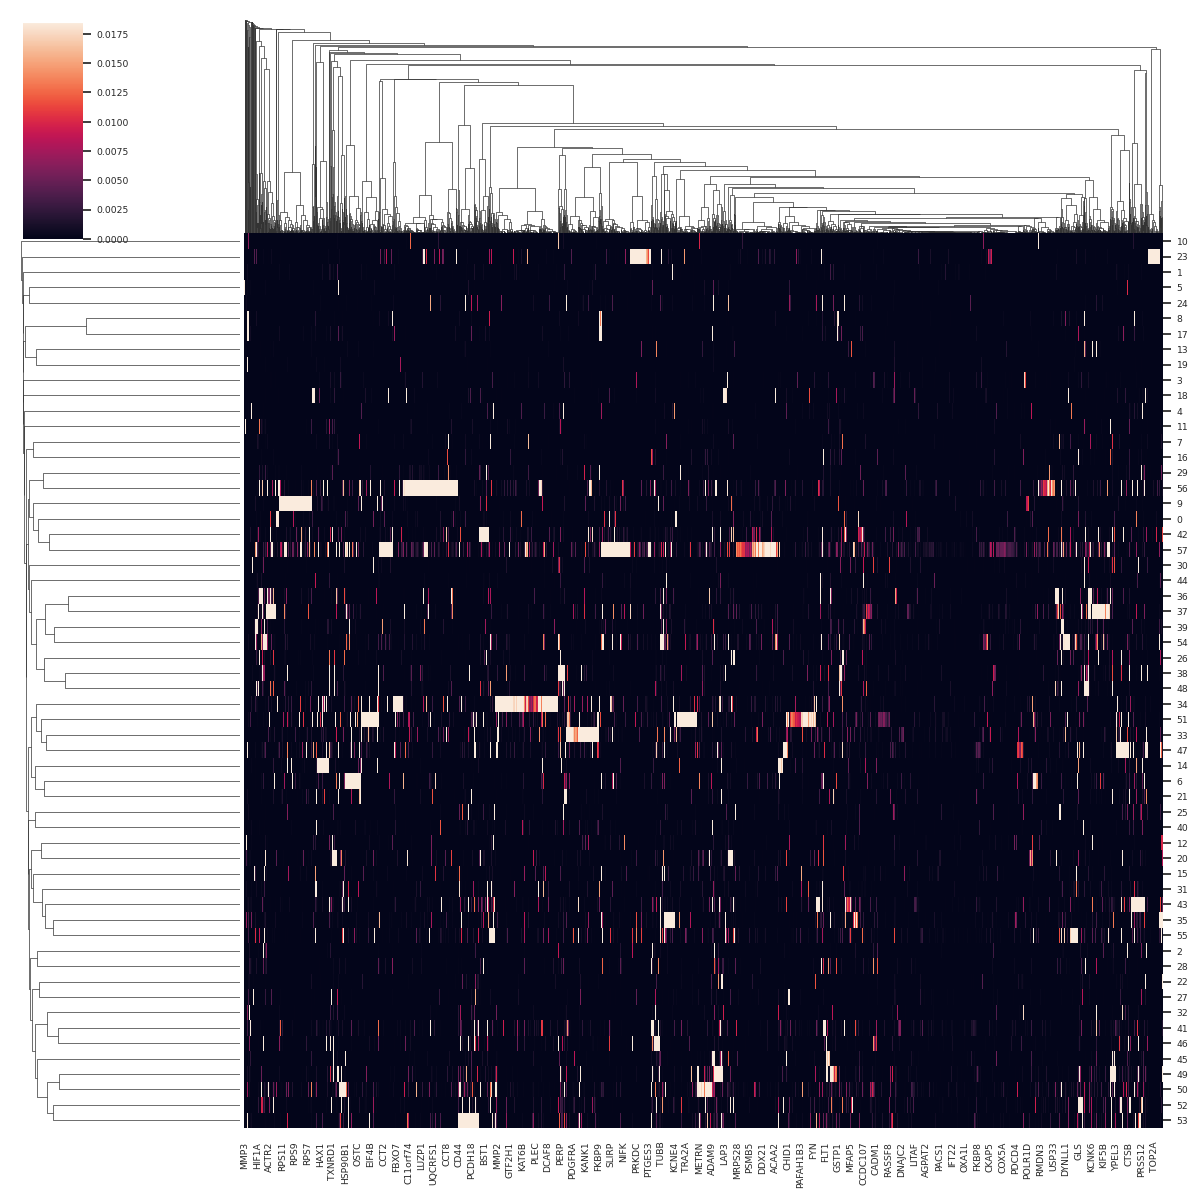

In [24]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(comps['fibro'], metric=hellinger)
Z = linkage(squareform(distance_matrix), method='average')

sns.set(font_scale=0.6)
sns.clustermap(comps['fibro'], robust=True, method='ward', row_linkage=Z, figsize=[12,12])

# Save results

In [33]:
bulk_codes['fibro'].to_csv('20240331_fibroblast_bulk_codes.csv')

In [34]:
bulk_codes['total_fibro'].to_csv('20240331_total_fibroblast_bulk_codes.csv')

In [35]:
bulk_comps['fibro'].to_csv('20240331_fibroblast_bulk_comps.csv')